In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [2]:
housing = pd.read_csv(r'C:\Users\Rog\Desktop\Housing\train.csv')

In [3]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
housing.shape

(1460, 81)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Check Nulls

<AxesSubplot:>

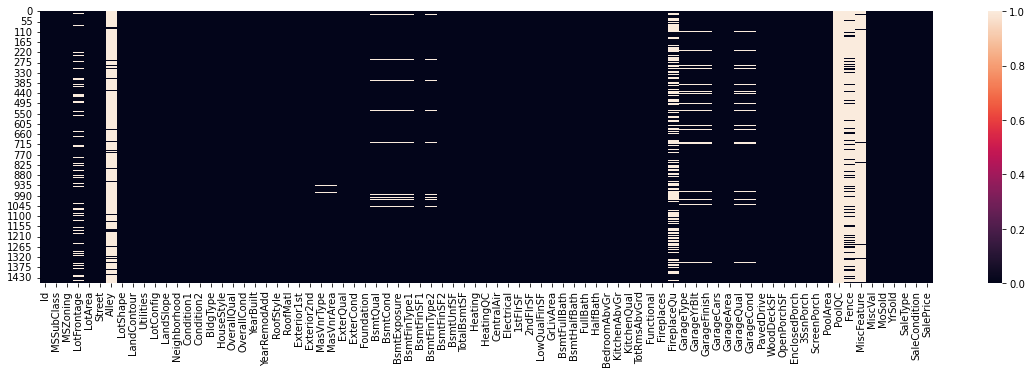

In [7]:
plt.figure(figsize=(20,5))

sns.heatmap(housing.isnull())

<AxesSubplot:>

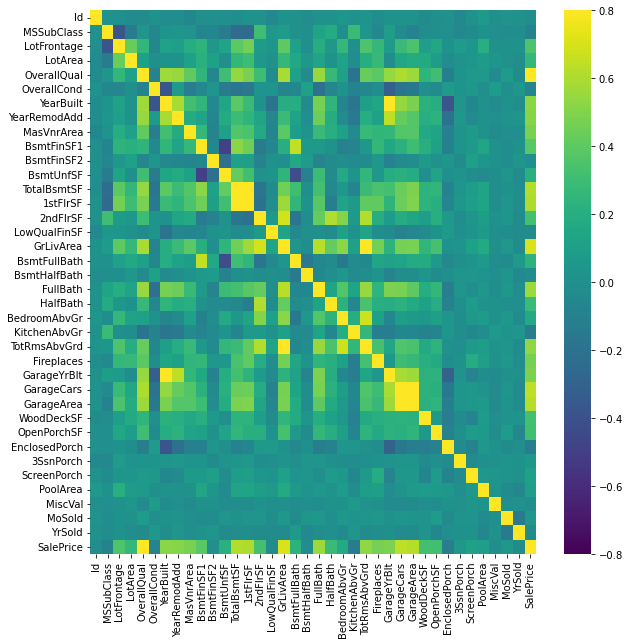

In [8]:
# Check Corr
plt.figure(figsize=(10,10))
sns.heatmap(housing.corr(), cmap='viridis', vmin = -0.8, vmax = 0.8 )

In [9]:
# Lets see the columns with nulls with respective number of nulls and follow one by one
housing.isnull().sum()[housing.isnull().sum() > 0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [10]:
y = np.log1p(housing['SalePrice'])
housing.drop('SalePrice', axis = 1, inplace = True)

In [13]:
# Impute and create missing indicator fields
def impute_and_indicate(df, col):
    df[col + "_ind"] = df[col].apply(lambda x: 0 if pd.isna(x) else 1)
    if df[col].dtype == 'O':
        df[col] = df[col].fillna("No")
    else:
        df[col] = df[col].fillna(0)

In [14]:
def preprocess(df):
    
    # MSSubclass & "MoSold" are Categories so we should change their dtype to "object"
    df = df.astype({"MSSubClass" : "object", "MoSold" : "object"})
    
    # Binary Encoding
    c_binary = ['hasPool', 'hasMiscFeature', 'hasAlley', 'hasFence']
    
    df['hasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df.drop(['PoolArea', 'PoolQC'], axis = 1, inplace = True)
    
    df['hasMiscFeature'] = df['MiscFeature'].apply(lambda x: 0 if pd.isna(x) else 1)
    df.drop(['MiscFeature'], axis = 1, inplace = True)
    
    df['hasAlley'] = df['Alley'].apply(lambda x: 0 if pd.isna(x) else 1)
    df.drop(['Alley'], axis = 1, inplace = True)
    
    df['hasFence'] = df['Fence'].apply(lambda x: 0 if pd.isna(x) else 1)
    df.drop(['Fence'], axis = 1, inplace = True)
    
    # Imputation
    c_imp = ['FireplaceQu', 'LotFrontage', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
               'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrType', 'MasVnrArea']
    
    for col in c_imp:
        impute_and_indicate(df, col)
    
    c_ind = [col for col in df.columns if '_ind' in col]
    
    df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
    
    # Drop Columns
    
    # Drop ID
    df.drop('Id', axis = 1, inplace = True)
    
    # Drop columns with High correlation
    df.drop(['GarageArea', '1stFlrSF', 'YearRemodAdd', 'TotRmsAbvGrd', 'BsmtUnfSF', 'BsmtFullBath'],
                 axis = 1, inplace = True)
    
    # Drop GarageBlt
    df.drop('GarageYrBlt', axis = 1, inplace = True)
    
    # Encode Features
    c_encoded = ['GarageQual', 'GarageCond', 'LotShape', 'Utilities', 'LandSlope', 'ExterQual',
            'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'PavedDrive']

    df['GarageQual'] = df['GarageQual'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    df['GarageCond'] = df['GarageCond'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    df['LotShape'] = df['LotShape'].replace({
        'IR3' : 1 , 'IR2' : 2, 'IR1' : 3, 'Reg' : 4
    })

    df['Utilities'] = df['Utilities'].replace({
        'ELO' : 1, 'NoSeWa' : 2, 'NoSewr' : 3, 'AllPub' : 4
    })
    
    df['LandSlope'] = df['LandSlope'].replace({
        'Gtl' : 1, 'Mod' : 2, 'Sev' : 3
    })
    
    df['ExterQual'] = df['ExterQual'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })
    
    df['ExterCond'] = df['ExterCond'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })
    
    df['BsmtQual'] = df['BsmtQual'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })
    
    df['BsmtCond'] = df['BsmtCond'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    df['BsmtExposure'] = df['BsmtExposure'].replace({
        'No' : 0, 'Mn' : 1, 'Av' : 2, 'Gd' : 3
    })
    
    df['BsmtFinType1'] = df['BsmtFinType1'].replace({
        'No' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6
    })
    
    df['BsmtFinType2'] = df['BsmtFinType2'].replace({
        'No' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6
    })
    
    df['HeatingQC'] = df['HeatingQC'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })
    
    df['KitchenQual'] = df['KitchenQual'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })
    
    df['Functional'] = df['Functional'].replace({
        'Sal' : 1, 'Sev' : 2, 'Maj1' : 3, 'Maj2' : 3, 'Mod' : 4, 'Min1' : 5, 'Min2' : 5, 'Typ' : 6
    })
    
    df['FireplaceQu'] = df['FireplaceQu'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })
    
    df['GarageFinish'] = df['GarageFinish'].replace({
        'No' : 0, 'Unf' : 1, 'RFn' : 2, 'Fin' : 3
    })
    
    df['PavedDrive'] = df['PavedDrive'].replace({
        'N' : 1, 'P' : 2, 'Y' : 3
    })
    
    # Simplify Features
    c_simple = ['OverallQual', 'OverallCond']
    
    housing['OvarallQual'] = housing.OverallQual.replace({
        1 : 1, 2 : 1, 3 : 1, 4 : 1,
        5 : 2, 6 : 2, 7 : 2,
        8 : 3, 9 : 3, 10 : 3
    })
    
    df['OvarallCond'] = df.OverallCond.replace({
        1 : 1, 2 : 1, 3 : 1, 4 : 1,
        5 : 2, 6 : 2, 7 : 2,
        8 : 3, 9 : 3, 10 : 3 
    })
    
    
    # Process Features
    cat_features = df.select_dtypes(include = ["object"]).columns
    num_features = df.select_dtypes(exclude = ["object"]).columns

    df_cat = df[cat_features]
    df_num = df[num_features].drop(c_binary, axis = 1)
    df_num = df_num.drop(c_encoded, axis = 1)
    df_num = df_num.drop(c_simple, axis = 1)
    df_num = df_num.drop(c_ind, axis = 1)
    
    # Normalize with Log
    skewness = df_num.apply(lambda x: skew(x))
    skewness = skewness[abs(skewness) > 0.5]
    skewed_features = skewness.index
    df[skewed_features] = np.log1p(df_num[skewed_features])
    
    # Get Dummies
    df_cat = pd.get_dummies(df_cat, drop_first = True)
    
    # Concat to get final X
    X = pd.concat([df_num, df_cat, df[c_binary], df[c_encoded], df[c_simple], df[c_ind]], axis = 1)
    
    return X, num_features


In [15]:
X, num_features = preprocess(housing)

# Split data into Train and Test

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train.loc[:, num_features] = scaler.fit_transform(X_train.loc[:, num_features])
X_test.loc[:, num_features] = scaler.fit_transform(X_test.loc[:, num_features])

C:\Users\Rog\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Rog\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


# Model Selection

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

In [20]:
def predict(X_train, y_train, X_test, y_test, elasticnet_a = 0.01):
    model = []
    rmse = []
    
    # Polynomial
    polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 2, include_bias = False)),
    ("lin_reg", LinearRegression())
    ])
    
    polynomial_regression.fit(X_train, y_train)
    y_pred = polynomial_regression.predict(X_test)
    
    model.append('Polynomial')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # RidgeCV
    ridge_reg = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 13, 17, 22, 30, 60])
    ridge_reg.fit(X_train, y_train)
    y_pred = ridge_reg.predict(X_test)
    
    alpha = ridge_reg.alpha_
    
    model.append('RidgeCV')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # Lasso
    lasso_reg = LassoCV(alphas = [0.001, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 13, 17, 22, 30])
    lasso_reg.fit(X_train, y_train)
    y_pred = lasso_reg.predict(X_test)
    
    model.append('LassoCV')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    
    # LassoLarsCV
    lasso_lars = LassoLarsCV(max_iter = 10000)
    lasso_lars.fit(X_train, y_train)
    y_pred = lasso_lars.predict(X_test)
    
    model.append('LassoLarsCV')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    
    # ElasticNet
    en_reg = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 1],
                        alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 13, 17, 22, 30, 60],
                        max_iter = 50000, cv = 10)
    en_reg.fit(X_train, y_train)
    y_pred = en_reg.predict(X_test)
    
    model.append('ElasticNet')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # SGDRegressor
    # sgd_reg = SGDRegressor()
    # sgd_reg.fit(X_train,y_train)
    # y_pred = sgd_reg.predict(X_test)
    
    # model.append('SGDRegressor')
    # rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # DecisionTreeRegressor
    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(X_train, y_train)
    y_pred = tree_reg.predict(X_test)
    
    model.append('DecisionTreeRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # RandomForestRegressor
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    
    model.append('RandomForestRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # GradientBoostingRegressor
    GBR_reg = GradientBoostingRegressor()
    GBR_reg.fit(X_train,y_train)
    y_pred = GBR_reg.predict(X_test)
    
    model.append('GradientBoostingRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # CatBoostRegressor
    cat_reg = GradientBoostingRegressor()
    cat_reg.fit(X_train,y_train)
    y_pred = cat_reg.predict(X_test)
    
    model.append('CatBoostRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # XGBRegressor
    xgbr_reg = XGBRegressor()
    xgbr_reg.fit(X_train,y_train)
    y_pred = xgbr_reg.predict(X_test)
    
    model.append('XGBRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    
    # Move values to DF & Sort ASC
    df = pd.DataFrame()
    df['model'] = model
    df['rmse'] = rmse
    
    df.sort_values('rmse', inplace=True)
    
    # Plot
    plt.figure(figsize = (10,5))
    sns.barplot(x = df['rmse'], y = df['model'])
    plt.show()
    
    print(df)
    return GBR_reg
    
    

C:\Users\Rog\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=1.220e-04, with an active set of 80 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\Rog\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=9.399e-05, with an active set of 95 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\Rog\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 105 iterations, i.e. alpha=8.696e-

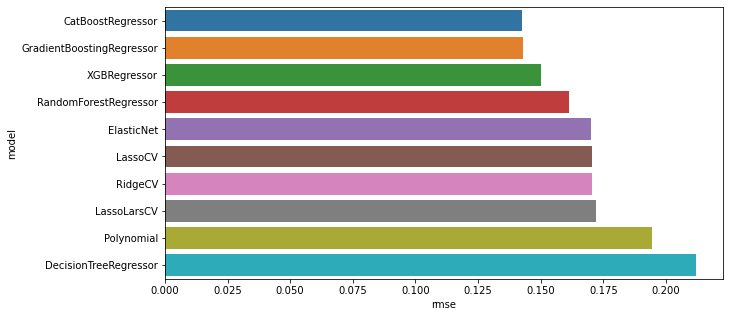

                       model      rmse
8          CatBoostRegressor  0.142691
7  GradientBoostingRegressor  0.143117
9               XGBRegressor  0.150224
6      RandomForestRegressor  0.161176
4                 ElasticNet  0.170048
2                    LassoCV  0.170436
1                    RidgeCV  0.170629
3                LassoLarsCV  0.171964
0                 Polynomial  0.194436
5      DecisionTreeRegressor  0.212148


GradientBoostingRegressor()

In [21]:
predict(X_train, y_train, X_test, y_test)

In [22]:
# Tune Ridge
from sklearn.linear_model import RidgeCV

ridge_reg = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 13, 17, 20, 22, 23, 30, 60])
ridge_reg.fit(X_train, y_train)

alpha = ridge_reg.alpha_
y_pred = ridge_reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.17063634906806965


In [23]:
ridge_reg = RidgeCV(alphas = [alpha, alpha * 0.85, alpha * 0.9, alpha * 0.95, alpha, alpha * 1.1, alpha * 1.2, alpha * 1.3])
ridge_reg.fit(X_train, y_train)
print(ridge_reg.alpha_)

23.0


Ridge picked 204 features and eliminated the other 1 features


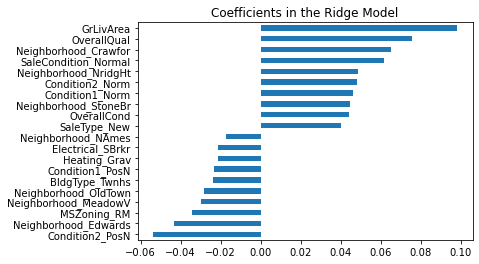

In [24]:
coefs = pd.Series(ridge_reg.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [25]:
housing_tr = pd.read_csv(r'C:\Users\Rog\Desktop\Housing\train.csv')
housing_te = pd.read_csv(r'C:\Users\Rog\Desktop\Housing\test.csv')

In [26]:
housing_tr.drop('SalePrice', axis = 1, inplace = True)

In [27]:
xgbr_reg = XGBRegressor()
xgbr_reg.fit(X_train,y_train)
y_pred = xgbr_reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.150224168369448


In [28]:
housing_te_id = housing_te['Id']

housing_te_pr, num_features = preprocess(housing_te)
housing_tr_pr, num_features = preprocess(housing_tr)

In [29]:
housing_tr_pr.columns.values

array(['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold',
       'OvarallCond', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Pave', 'LandContour_HLS', 'LandContour_Low',
       'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_FR3', 'LotConfig_Inside', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
  

In [30]:
housing_te_pr.shape

(1459, 191)

In [31]:
housing_tr_pr.shape

(1460, 205)

In [32]:
dummie_diff = list(set(housing_tr_pr.columns) - set(housing_te_pr.columns))

In [33]:
housing_te_pr[[dummie_diff]] = 0

In [34]:
housing_te_pred = xgbr_reg.predict(housing_te_pr)

In [35]:
housing_te_pred = np.expm1(housing_te_pred)

In [36]:
housing_te_pred

array([176244.6 , 211396.31, 168678.08, ..., 176347.66, 203369.94,
       222278.17], dtype=float32)

In [37]:
pred_df = pd.concat([housing_te_id, pd.Series(housing_te_pred)], axis=1)
pred_df.columns = ['Id', 'SalePrice']

In [38]:
pred_df.set_index('Id', inplace = True)